In [1]:
import itertools
import numpy as np
import operator 
from nltk.corpus import stopwords
import nltk
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from operator import is_not
from functools import partial
import networkx as nx
from ast import literal_eval
from statistics import median
from sklearn.cluster import KMeans
from networkx.algorithms.community import kernighan_lin_bisection
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms import community
import time

In [2]:
url_image='image_data/'
url = 'data/'

In [3]:
# Read a file of word vectors
df_word_vectors = pd.read_csv(url+'df_word_vectors.csv',converters={'tf-idf': eval,'wordvec': eval,'combine_vectors': eval}) 

In [4]:
df_word_vectors.shape

(11856, 4)

In [5]:
df_word_vectors[(df_word_vectors['word']=='c++') | (df_word_vectors['word']=='c') | (df_word_vectors['word']=='python') ]

,word,tf-idf,wordvec,combine_vectors
1635,python,"[0.0006271374803538901, 0.00032729640391741035...","[-0.25645, -0.22323, 0.025901, 0.22901, 0.4902...","[0.0006271374803538901, 0.00032729640391741035..."
5722,c++,"[0.0, 0.0, 0.0009565216486319976, 0.0031862511...","[0.29033, 0.42036, -0.77658, -0.19994, 1.014, ...","[0.0, 0.0, 0.0009565216486319976, 0.0031862511..."
10901,c,"[0.0, 0.0, 0.0012000489751841548, 0.0026649736...","[0.42345, -0.29531, -0.74547, -0.37288, -0.268...","[0.0, 0.0, 0.0012000489751841548, 0.0026649736..."


# **create graph of words**

In [6]:
class Graph(): 
    def cosine_similarity(self,vec_1,vec_2):
        """
        Cosine_similarity function
        A function that accepts two vectors as arguments.
        Returns the similarity cosine value of the vectors.
        """ 
        sim = np.dot(vec_1,vec_2)/(np.linalg.norm(vec_1)*np.linalg.norm(vec_2))
        return sim
    
    
    def create_graph(self,df_node,name_col):
        '''
        Create nodes and edge of graph
        '''
        G=nx.complete_graph(len(df_node))
        word_dictory = df_node['word'].to_dict()
        tf_idf_dict = df_node[name_col].to_dict()  
        # make nodes
        for i in range(len(df_node)):
            G.nodes[i]['word'] = word_dictory[i]
            G.nodes[i][name_col] = tf_idf_dict[i]
        #make edges with weight = cosine_similarity, remove all weight = 0     
        for e in G.edges():
            cosine_sim = self.cosine_similarity(tf_idf_dict[e[0]], tf_idf_dict[e[1]])
            if cosine_sim != 0:
                G.edges[e[0],e[1]]['cosine_similarity'] = cosine_sim
            else:
                G.remove_edge(*e[:2])             
        return G

    
    def add_word_rank(self,G):
        '''
        Add word rank values to the nodes of the graph
        '''
        wordsrank = []
        for i in range(len(G.nodes())):
            edges = G.edges(i)
            wordsrank.append((list(G.nodes()[i].keys())[0], sum([G[u][v]['cosine_similarity'] for u,v in edges])))
        sorted_ranks = sorted(wordsrank, key=lambda x: (x[1]), reverse=True)

        for i in range(len(G.nodes())):      
            G.nodes[i]['word_rank'] = sorted_ranks.index(wordsrank[i])
            G.nodes[i]['sum_cosine_similarity'] = wordsrank[i][1]
            
    
    def graph_nodes_to_dataframe(self,G):
        """
        A function that accepts a graph as an argument and inserts nodes values into a data frame.
        """
        nodelist = []
        for n,d in G.nodes(data=True):
            node_data = dict()
            node_data['node'] = n
            node_data.update(d)
            nodelist.append(node_data)
        return pd.DataFrame(nodelist) 
    

    def graph_edges_to_dataframe(self,G):
        """
        A function that accepts a graph as an argument and inserts edges values into a data frame.
        """
        edgelist = []
        for n1, n2, d in G.edges(data=True):
            edgeinfo = {'node1':n1, 'node2':n2}
            edgeinfo.update(d)
            edgelist.append(edgeinfo)
        return pd.DataFrame(edgelist)
    
    
    def graph_visualization(self,G,Tf_idf_word_vectors):
        '''
        Graph visualization function
        A function that displays a graph of words for similarity cosine values.
        '''
        pos = nx.spring_layout(G,iterations=2)
        nx.draw_networkx_edge_labels(G,pos,edge_labels={e:self.cosine_similarity(Tf_idf_word_vectors[e[0]][1],Tf_idf_word_vectors[e[1]][1]) for e in G.edges()},font_color='black')
        nx.draw_networkx(G,pos,edge_color='black',node_size=700,node_color='pink',alpha=0.9,labels={node: Tf_idf_word_vectors[node][0] for node in G.nodes()})
        plt.gcf().set_size_inches(20.5, 20.5, forward=True)  
        plt.title("Graph of cosine_similarity")
        plt.axis('off')
        #plt.savefig(url_image+'cosine_similarity_graph.png')  
        plt.show()
        plt.close()
        
    
    def create_graph_v2(self,df_node, alpha=0.5):
        """
        Create graph function
        A function that receives a data frame of word vectors and Alpha value for distance calculation.
        Returns a graph that the nodes are words and the edges are cosine similarity values.
        """ 

        word_dictory = df_node['word'].to_dict()
        tf_idf_dict = df_node['tf-idf'].to_dict()
        tf_idf_norm_dict = df_node['tf-idf_after_norm'].to_dict()
        word_vec_dict = df_node['wordvec'].to_dict()

        index_list = list(df_node['word'].to_dict().keys())

        G=nx.complete_graph(len(index_list))

        # make nodes
        for i in range(len(index_list)):
            G.nodes[i]['word'] = word_dictory[index_list[i]]
            G.nodes[i]['tf-idf'] = tf_idf_dict[index_list[i]]
            G.nodes[i]['tf-idf_after_norm'] = tf_idf_norm_dict[index_list[i]]
            G.nodes[i]['wordvec'] = word_vec_dict[index_list[i]]

        #make edges with weight and remove all weight = 0     
        for e in G.edges():
            tf_idf_cosine_sim = self.cosine_similarity(G.nodes[e[0]]['tf-idf'], G.nodes[e[1]]['tf-idf'])
            word_vec_cosine_sim = self.cosine_similarity(G.nodes[e[0]]['wordvec'], G.nodes[e[1]]['wordvec'])
            distance = alpha*(1 - tf_idf_cosine_sim) + (1 - alpha)*(1 - word_vec_cosine_sim)

            if tf_idf_cosine_sim != 0:
                G.edges[e[0],e[1]]['cosine_similarity'] = tf_idf_cosine_sim
                G.edges[e[0],e[1]]['distance'] = distance
            else:
                G.remove_edge(*e[:2])             
        return G


## graph of v1

In [ ]:
Tf_idf_word_vectors_v1 = list(df_word_vectors[['word','tf-idf']].to_records(index=False))
# Create a class object v1
graph_obj=Graph()
# Create a graph of cosine similarity Using vector representation v1
G = graph_obj.create_graph(df_word_vectors,'tf-idf')
# Add textrank results
graph_obj.add_word_rank(G)

# ***Save / read graph to file***

In [8]:
# Inserting vertices and edges of a graph in a data frame
df_node = graph_obj.graph_nodes_to_dataframe(G).set_index(['node'])
edges_df = graph_obj.graph_edges_to_dataframe(G)

In [9]:
# Save the vertices and edges of a graph v1 within a csv file
df_node.to_csv(url+'df_node_v1.csv',index=False)
edges_df.to_csv(url+'edges_df_v1.csv',index=False,header=True)

In [7]:
df_node = pd.read_csv(url+'df_node.csv',converters={'tf-idf': eval}) 

In [8]:
print(df_node.shape)
df_node[(df_word_vectors['word']=='c++') | (df_node['word']=='c') | (df_node['word']=='python') ]

(11856, 4)


,word,tf-idf,word_rank,sum_cosine_similarity
4565,python,"[0.0006271374803538901, 0.00032729640391741035...",29,888.224363
5722,attackers,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4634,102.746847
7524,c,"[0.0, 0.0, 0.0012000489751841548, 0.0026649736...",268,557.597989


In [12]:
edges_df=pd.read_csv(url+'edges_df.csv',converters={'tf-idf': eval}) 

In [13]:
print(edges_df.shape)
edges_df.head()

(8269176, 3)


,node1,node2,cosine_similarity
0,0,20,0.124445
1,0,29,0.117547
2,0,81,0.118007
3,0,85,0.037126
4,0,105,0.032321


## graph of v3

In [14]:
Tf_idf_word_vectors_v3 = list(df_word_vectors[['word','combine_vectors']].to_records(index=False))
# Create a class object
graph_obj=Graph()
# Create a graph of cosine similarity Using vector representation v3
G = graph_obj.create_graph(df_word_vectors[:20],'combine_vectors')
# Add textrank results
graph_obj.add_word_rank(G)

# ***Save / read graph v3 to file***

In [15]:
# Inserting vertices and edges of a graph in a data frame
df_node = graph_obj.graph_nodes_to_dataframe(G).set_index(['node'])
edges_df = graph_obj.graph_edges_to_dataframe(G)

In [16]:
# Save the vertices and edges of a graph v3 within a csv file
df_node.to_csv(url+'df_node_v3.csv',index=False)
edges_df.to_csv(url+'edges_df_v3.csv',index=False,header=True)

In [9]:
df_node = pd.read_csv(url+'df_node_v3.csv',converters={'combine_vectors': eval}) 

In [10]:
print(df_node.shape)
df_node[(df_word_vectors['word']=='c++') | (df_node['word']=='c') | (df_node['word']=='python') ]

(11856, 4)


,word,combine_vectors,word_rank,sum_cosine_similarity
1635,python,"[0.0006271374803538901, 0.00032729640391741035...",978,3158.749562
5722,c++,"[0.0, 0.0, 0.0009565216486319976, 0.0031862511...",3178,2713.187231
10901,c,"[0.0, 0.0, 0.0012000489751841548, 0.0026649736...",7122,904.121945


In [19]:
edges_df=pd.read_csv(url+'edges_df_v3.csv',converters={'combine_vectors': eval}) 

In [20]:
print(edges_df.shape)
edges_df.head()

(30977754, 3)


,node1,node2,cosine_similarity
0,0,1,0.072022
1,0,2,0.079252
2,0,4,0.000416
3,0,5,0.213664
4,0,6,0.228124


## graph of v2

### Linear interpolation and remove zero vectors

In [21]:
def interpolation_linear(df):
    '''
    A function that receives a list and performs a linear interpolation.
    For each particular zero value that is between two neighbors different from zero "guesses" a missing value
    and replaces its value according to the formula x1*alpha+(1-alpha)*x2.
    for vector x1 0 x2
    x1=The neighbor on the right=df.iloc[col].shift(1)
    x2=The neighbor on the left=df.iloc[col].shift(-1)
    alpha=0.4
    The function returns a new data frame
    '''
    for col in range(len(df)):
        df.iloc[col]=np.where((df.iloc[col].values==0)&(df.iloc[col].shift(-1)!=0)&(df.iloc[col].shift(1)!=0),df.iloc[col].shift(1)*0.4+0.6*df.iloc[col].shift(-1),df.iloc[col])
    return df.fillna(0).values.tolist()  

In [22]:
df_interpolation_linear=df_word_vectors

In [23]:
df_interpolation_linear['tf-idf_new']=interpolation_linear( pd.DataFrame(df_interpolation_linear['tf-idf'].to_list()))

In [24]:
def removal_vector_zero(df00):
    '''
    A function that accepts as a data frame argument.
    The function removes rows that contain a lot of zero values and returns a new data frame.
    '''
    df00['size'] = df00['tf-idf'].apply(lambda x:699 - x.count(0))
    df00['size_new'] = df00['tf-idf_new'].apply(lambda x:699 - x.count(0))
    print(df00[df00['size'] >= 110].shape, df00[df00['size_new'] >= 110].shape)
    df01 = df00[df00['size_new'] >= 110]
    return df01

In [25]:
df_remove_vector_zero= removal_vector_zero(df_interpolation_linear)
df_remove_vector_zero.head()

(482, 7) (514, 7)


,word,tf-idf,wordvec,combine_vectors,tf-idf_new,size,size_new
8,need,"[0.0, 0.0, 0.0, 0.0, 0.0036716884691551425, 0....","[-0.067028, 1.1607, -0.56576, -0.37301, -0.273...","[0.0, 0.0, 0.0, 0.0, 0.0036716884691551425, 0....","[0.0, 0.0, 0.0, 0.0, 0.0036716884691551425, 0....",135,152
13,research,"[0.0, 0.00045639043668804574, 0.00120531510865...","[0.38054, 0.56599, -0.81505, -0.52665, 1.3219,...","[0.0, 0.00045639043668804574, 0.00120531510865...","[0.0, 0.00045639043668804574, 0.00120531510865...",443,503
14,multi,"[0.0, 0.0, 0.0, 0.0016605117254455248, 0.0, 0....","[-0.11558, -0.31491, -0.42213, -0.54713, 1.108...","[0.0, 0.0, 0.0, 0.0016605117254455248, 0.0, 0....","[0.0, 0.0, 0.0, 0.0016605117254455248, 0.0, 0....",128,138
20,equivalent,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005340869572...","[0.52729, 0.23006, 0.22676, -0.6095, 0.7245, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005340869572...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005340869572...",317,358
65,aspect,"[0.0, 0.0, 0.0, 0.0012897197504711316, 0.00147...","[0.2398, -0.34849, -1.1041, 0.54465, 1.0651, 0...","[0.0, 0.0, 0.0, 0.0012897197504711316, 0.00147...","[0.0, 0.0, 0.0, 0.0012897197504711316, 0.00147...",187,199


In [26]:
# # Read a file of word vectors normalize
df_normalize = pd.read_csv(url+'df_word_vectors_normalize.csv', converters={'tf-idf': eval,'tf-idf_after_norm':eval}) 

In [27]:
# remove col from data frames
df_remove_col=df_remove_vector_zero.drop(['tf-idf','tf-idf_new','size','size_new'], axis=1)
# Merge two data frames
df_merge_data=pd.merge(df_normalize,df_remove_col, on=("word"))
df_merge_data.head()

,word,tf-idf,tf-idf_after_norm,wordvec,combine_vectors
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619..."
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...","[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177..."
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...","[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0...."
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
# Create a class object v3
graph_obj=Graph()

In [29]:
%%time
# Create a graph of cosine similarity Using vector representation v2
G = graph_obj.create_graph_v2(df_merge_data)

<ipython-input-6-41ee157379e3>:8: RuntimeWarning: invalid value encountered in double_scalars
  sim = np.dot(vec_1,vec_2)/(np.linalg.norm(vec_1)*np.linalg.norm(vec_2))


Wall time: 20.3 s


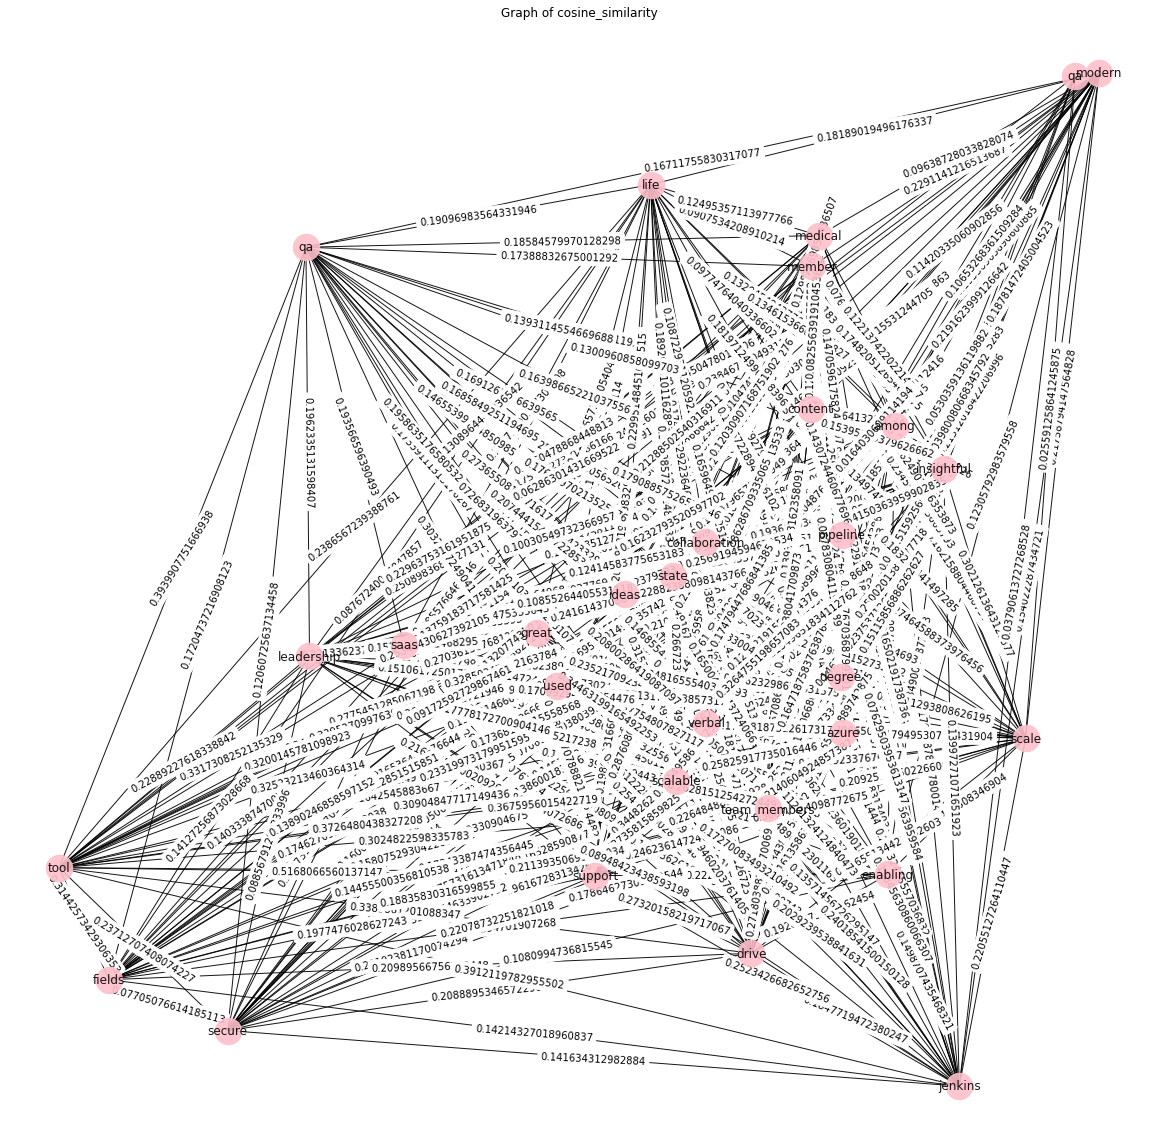

In [30]:
Tf_idf_word_vectors_v2 = list(df_merge_data[['word','tf-idf']].to_records(index=False))
# Show an example of an cosine similarity graph
graph_obj.graph_visualization(G.subgraph(range(30)),  Tf_idf_word_vectors_v2 )

In [31]:
# Add textrank results
graph_obj.add_word_rank(G)

# ***Save / read graph to file***

In [32]:
# Inserting vertices and edges of a graph in a data frame
df_node = graph_obj.graph_nodes_to_dataframe(G).set_index(['node'])
edges_df = graph_obj.graph_edges_to_dataframe(G)
# Removal of words with zero distance
edges_df=edges_df.dropna()

In [33]:
# Save the vertices and arcs of a graph v2 within a csv file
df_node.to_csv(url+'df_nodes_algorithms.csv',index=False)
edges_df.to_csv(url+'df_edges_algorithms.csv',index=False,header=True)

In [34]:
# Reading a csv file that contains nodes of the graph
df_node = pd.read_csv(url+'df_nodes_algorithms.csv',  converters={'tf-idf': eval, 'tf-idf_after_norm':eval,'wordvec':eval}) 

In [35]:
print(df_node.shape)
df_node.head()

(514, 6)


,word,tf-idf,tf-idf_after_norm,wordvec,word_rank,sum_cosine_similarity
0,modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00155619...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29355458...","[-0.24942, -0.73219, 0.17863, -0.29171, 1.0194...",283,109.704459
1,saas,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021683, 0.28122, -0.87629, -0.2346, -0.0122...",300,107.480757
2,used,"[0.0, 0.0, 0.0, 0.0015521196808122063, 0.00177...","[0.0, 0.0, 0.0, 0.32159919786428914, 0.3215991...","[0.47751, 0.13662, 0.47026, -0.34915, -0.05846...",331,104.355574
3,among,"[0.0018083251886995833, 0.0, 0.0, 0.0, 0.0, 0....","[0.3822799448910919, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.68472, -0.08644, -0.11884, -0.1911, 0.24869...",460,90.295322
4,enabling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.86696, -0.019402, -0.89041, 0.31414, 0.299...",426,94.068587


In [36]:
# Reading a csv file that contains edges of the graph
edges_df=pd.read_csv(url+'df_edges_algorithms.csv') 

In [37]:
print(edges_df.shape)
edges_df.head()

(105111, 4)


,node1,node2,cosine_similarity,distance
0,0,1,0.238468,0.737669
1,0,2,0.146363,0.614132
2,0,3,0.193370,0.555648
3,0,4,0.123058,0.750495
4,0,5,0.151529,0.633940
